<a href="https://colab.research.google.com/github/helakhaddar/Moteur-de-Recherche-d-images-par-le-contenu-Approche-classique/blob/main/MoteurDeRecherche.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moteur de Recherche d'images par le contenu - Approche classique

---


Fait par:

> Bajar Imen - Khaddar Hela



## Indexation

In [ ]:
import cv2
import numpy as np
import tarfile
import os
import json
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### Histogramme de **couleur**

In [ ]:
def calculate_histogram(image_path, N):

    image =cv2.imread(image_path)
    # Diviserchaque axe de l'espace de couleurs en N intervalles
    hist_bins = [N, N, N]

    try:
        histogram = cv2.calcHist([image], [0, 1, 2], None, hist_bins,  [0, 256, 0, 256, 0, 256])
    except cv2.error as e:
        print(f"Error calculating histogram: {e}")
        return None

    # Normaliser l'histogramme
    histogram = cv2.normalize(histogram, histogram).flatten().tolist()

    return histogram


In [ ]:
def index_images(input_tar_file, output_index_file):
    histogram_list = []
    image_list = [file for file in os.listdir(input_tar_file) if file.lower().endswith(('.jpg'))]
    for filename in image_list:
        image_path = os.path.join(input_tar_file, filename)
        histogram = calculate_histogram(image_path, 8)
        histogram_list.append({'image_path': image_path, 'histogram': histogram})

    with open(output_index_file, 'w') as json_file:
        json.dump(histogram_list, json_file, indent=2)

In [ ]:
input_tar_file ="/content/Dataset"
directory_path ="/content/drive/MyDrive/BE"
output_index_file ="img_indices.json"
index_images(directory_path,output_index_file)

### descripteur de texture
---



In [ ]:
import cv2
import numpy as np

def texture_descriptor(image_path):
    # Charger l'image en niveaux de gris
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Calculer la Transformée de Fourier 2D
    fft_image = np.fft.fft2(image)

    # Obtenir le spectre en amplitude
    amplitude_spectrum = np.abs(fft_image)

    # Découper la moitié supérieure en 6x3 blocs
    blocks = np.array_split(amplitude_spectrum[:amplitude_spectrum.shape[0]//2, :], 6, axis=0)
    blocks = [np.array_split(block, 3, axis=1) for block in blocks]

    # Calculer le logarithme de l'énergie moyenne sur chaque bloc
    descriptors = [np.log(np.mean(np.square(block))) for row in blocks for block in row]

    return descriptors

In [ ]:
def process_images_directory(directory_path,output_index_file):
    descriptors_list = []
    image_list = [file for file in os.listdir(directory_path) if file.lower().endswith(( '.jpg'))]
    for filename in image_list:
         image_path = os.path.join(directory_path, filename)
         descriptors = texture_descriptor(image_path)
         descriptors_list.append({"filename": image_path, "descriptors": descriptors})

    with open(output_index_file, 'w') as json_file:
        json.dump(descriptors_list, json_file, indent=2)


In [ ]:
#directory_path = "/content/Dataset"

output_index_file ="img_descriptors.json"
process_images_directory(directory_path,output_index_file)

## Recherche


In [ ]:
def euclidean_distance(hist1,hist2):
  distance = np.sqrt(np.sum(np.square(np.array(hist1) - np.array(hist2))))
  return distance

In [ ]:
def calcul_similarité_histogramme(img_requete_path,json_file):
  histogram_requete = calculate_histogram(img_requete_path,8)
  with open(json_file, 'r') as f:
        data = json.load(f)
  distances = []
  for entry in data:
        image_name = entry["image_path"]
        histogram = entry["histogram"]
        # Calculer la distance eucliedienne entre les histogrammes
        distance = euclidean_distance(histogram_requete, histogram)
        distances.append((distance,image_name))
  distances.sort()
  top3 =distances[:3]
  return top3

In [ ]:
calcul_similarité_histogramme("/content/drive/MyDrive/BE/04.jpg","/content/img_indices.json")

[(0.0, '/content/drive/MyDrive/BE/04.jpg'),
 (0.5909956541151965, '/content/drive/MyDrive/BE/24.jpg'),
 (0.6034255028728129, '/content/drive/MyDrive/BE/23.jpg')]

In [ ]:
calcul_similarité_histogramme("/content/Dataset/04.jpg","/content/img_indices.json")

In [ ]:
def manhattan_distance(descriptor1, descriptor2):
    # Calcul de la distance de Manhattan entre deux descripteurs
    return np.sum(np.abs(np.array(descriptor1) - np.array(descriptor2)))

In [ ]:
def calcul_similarité_texture(img_requete_path,json_file):
  descriptors=texture_descriptor(img_requete_path)
  with open(json_file, 'r') as f:
        data = json.load(f)
  distances = []
  for entry in data:
        image_name = entry["filename"]
        descriptor = entry["descriptors"]
        # Calculer la distance de Manhattan entre les descripteurs
        distance = manhattan_distance(descriptors, descriptor)

        # Ajouter la distance et le nom de l'image à la liste
        distances.append((distance, image_name))

  distances.sort()

    # Récupérer les trois images les plus similaires
  top3_similar_images = distances[:3]

  return top3_similar_images

In [ ]:
calcul_similarité_texture("/content/drive/MyDrive/BE/04.jpg","/content/img_descriptors.json")

[(0.0, '/content/drive/MyDrive/BE/04.jpg'),
 (6.780847509067696, '/content/drive/MyDrive/BE/13.jpg'),
 (9.311986924924991, '/content/drive/MyDrive/BE/22.jpg')]

In [ ]:
calcul_similarité_texture("/content/Dataset/04.jpg","/content/img_descriptors.json")

## Recherche avec descripteur de gabor

In [ ]:
def extract_gabor_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    ksize = 11
    sigma = 6.0
    theta = 0.8
    lambd = 10.0
    gamma = 0.5
    gabor_filter = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)
    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_filter)
    features = np.ravel(filtered_image)  # Flatten the 2D array into a 1D vector
    #normalized_features = cv2.normalize(features, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    return features

In [ ]:
def process_images_directory(directory_path,output_index_file):
  descriptorsg_list = []
  image_list = [file for file in os.listdir(directory_path) if file.lower().endswith(( '.jpg'))]
  for filename in image_list:
    image_path = os.path.join(directory_path, filename)
    features = extract_gabor_features(image_path)
    features_list = [feature.tolist() for feature in features]
    descriptorsg_list.append({"filename": image_path, "descriptors": features_list})

  with open(output_index_file, 'w') as json_file:
        json.dump(descriptorsg_list, json_file, indent=2)

In [ ]:
directory_path ="/content/drive/MyDrive/BE"
output_index_file ="img_gabor_des.json"
process_images_directory(directory_path, output_index_file)

In [ ]:
def Calcul_similarité_gabor(rq_image_path, json_file):
    query_features = extract_gabor_features(rq_image_path)

    with open(json_file, 'r') as f:
        data = json.load(f)

    # Compare the query features with database features
    similarities = {}
    for entry in data:
        image_name = entry["filename"]
        features = entry["descriptors"]
        if not np.any(np.isfinite(query_features)) or not np.any(np.isfinite(features)):
            continue
        similarity = np.corrcoef(query_features, features)[0, 1]

        # Check if the similarity is not nan before adding to the dictionary
        if not np.isnan(similarity):
            similarities[image_name] = similarity

    # Sort images by similarity
    sorted_images = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    top3= sorted_images[:3]

    return top3

In [ ]:
Calcul_similarité_gabor("/content/drive/MyDrive/BE/15.jpg","/content/img_gabor_des.json")

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[('/content/drive/MyDrive/BE/15.jpg', 1.0),
 ('/content/drive/MyDrive/BE/31.jpg', 0.06992969787357108),
 ('/content/drive/MyDrive/BE/06.jpg', 0.06812415843683751)]

## Interface graphique

FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Rechercher par histogramme', style=ButtonStyle())

Button(description='Rechercher par texture', style=ButtonStyle())

Button(description='Rechercher Gabor methods', style=ButtonStyle())

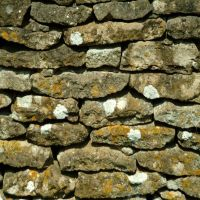

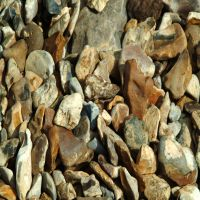

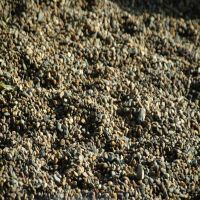

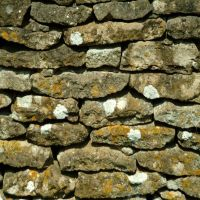

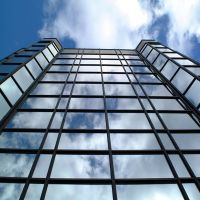

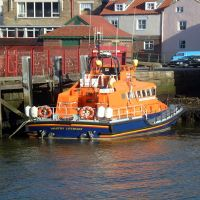

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


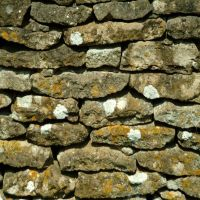

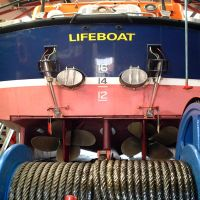

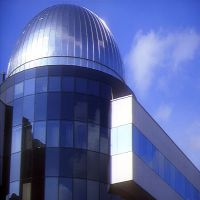

In [ ]:
from google.colab import files
import cv2
import numpy as np
from scipy.spatial import distance
from PIL import Image
from IPython.display import display, Image

import ipywidgets as widgets

class ImageSearchAppColab:
    def __init__(self):
        self.image_path = ""

        # Interface elements

        self.image_button = widgets.FileUpload(accept='image/*', multiple=False)
        self.image_button.observe(self.on_upload, names='value')

        self.histogram_button = widgets.Button(description="Rechercher par histogramme")
        self.histogram_button.on_click(self.search_images_histogram)

        self.texture_button = widgets.Button(description="Rechercher par texture")
        self.texture_button.on_click(self.search_images_texture)

        self.gabor_button = widgets.Button(description="Rechercher Gabor methods")
        self.gabor_button.on_click(self.search_images_gabor)


    def on_upload(self, change):
        if change['new']:
            # Get the uploaded image
            uploaded_image = list(change['new'].values())[0]
            content = uploaded_image['content']
            self.image_path = self.save_image(content)

    def save_image(self, content):
        image_path = "/content/query_image.jpg"
        with open(image_path, 'wb') as f:
            f.write(content)
        return image_path

  #affichage des images
    def display_images(self, image_paths):
        for path in image_paths:
            display(Image(filename=path, width=200, height=200))

    def search_images_histogram(self, b):
        top3 = calcul_similarité_histogramme(self.image_path, "/content/img_indices.json")
        image_paths = [image_name for _, image_name in top3]
        self.display_images(image_paths)

    def search_images_texture(self, b):

        top3=calcul_similarité_texture(self.image_path,"/content/img_descriptors.json")

        image_paths = [filename for _, filename in top3]

        self.display_images( image_paths)

    def search_images_gabor(self, b):
        top3=Calcul_similarité_gabor(self.image_path,"/content/img_gabor_des.json")
        image_paths = [image_name for image_name, _  in top3]
        self.display_images(image_paths)

# Create an instance of ImageSearchAppColab
app_colab = ImageSearchAppColab()

display(app_colab.image_button)
display(app_colab.histogram_button)
display(app_colab.texture_button)
display(app_colab.gabor_button)
